In [1]:
import os
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
import scipy.io as sio
import scipy.io.wavfile
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import sounddevice as sd
import warnings
from pathlib import Path
from matplotlib import font_manager, rc

In [2]:
# 시각화 그릴 때 제목이나 축 이름 한글 깨짐 방지
path = "c:/windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=path).get_name()
rc('font', family=font_name)
# 출력 할때 경고 메시지 숨기기
warnings.filterwarnings(action='ignore')
# 현재 가상환경에 설치된 패키지 확인
!pip list

Package                      Version
---------------------------- ------------
absl-py                      2.1.0
asttokens                    2.4.1
astunparse                   1.6.3
audioread                    3.0.1
Bashutils                    0.0.4
certifi                      2024.2.2
cffi                         1.16.0
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
exceptiongroup               1.2.0
executing                    2.0.1
flatbuffers                  24.3.25
fonttools                    4.52.4
gast                         0.5.4
google-pasta                 0.2.0
grpcio                       1.64.0
h5py                         3.11.0
idna                         3.7
importlib_metadata           7.1.0
importlib_resources          6.4.0
ipykernel                    6.29.3
ip

In [3]:
# 데이터셋이 들어있는 경로 불러오기
data_dir =r"D:/Desktop/AI_programming/Final/Dataset_전자부품(음향기기) 품질보증 AI 데이터셋/data2"
# os모듈의 listdir을 사용해 위에서 지정한 데이터셋들이 들어있는 폴더 목록을 확인한다.
folder_names = os.listdir(data_dir)

print(folder_names)

['abnorm', 'normal']


In [4]:
# 파일을 리스트로 저장할 임시변수를 생성한다.
file_temp_list = []
# 디렉토리 안에 있는 폴더들을 찾아 하나의 리스트로 만든다.
# 데이터셋이 들어있는 폴더를 찾아 folder에 넣어준다
for folder in Path(data_dir).iterdir():
    # 각 폴더 안에 들어있는 파일들을 하나씩 꺼내 file_temp 에 넣어준다.
    for file_temp in Path(folder).iterdir():
        # file_temp_list안에 데이터셋을 쌓는다
        file_temp_list.append(file_temp)
# str로 변환
file_list=list(map(str, file_temp_list))
# 각 파일 중 음원파일(확장자명 wav)만 추출하기
file_names_p = [file_name for file_name in file_list if'.wav' in file_name]
# wav로 추출된 파일을 확인한다.
file_names_p

['D:\\Desktop\\AI_programming\\Final\\Dataset_전자부품(음향기기) 품질보증 AI 데이터셋\\data2\\abnorm\\abnorm_1.wav',
 'D:\\Desktop\\AI_programming\\Final\\Dataset_전자부품(음향기기) 품질보증 AI 데이터셋\\data2\\abnorm\\abnorm_10.wav',
 'D:\\Desktop\\AI_programming\\Final\\Dataset_전자부품(음향기기) 품질보증 AI 데이터셋\\data2\\abnorm\\abnorm_100.wav',
 'D:\\Desktop\\AI_programming\\Final\\Dataset_전자부품(음향기기) 품질보증 AI 데이터셋\\data2\\abnorm\\abnorm_101.wav',
 'D:\\Desktop\\AI_programming\\Final\\Dataset_전자부품(음향기기) 품질보증 AI 데이터셋\\data2\\abnorm\\abnorm_102.wav',
 'D:\\Desktop\\AI_programming\\Final\\Dataset_전자부품(음향기기) 품질보증 AI 데이터셋\\data2\\abnorm\\abnorm_103.wav',
 'D:\\Desktop\\AI_programming\\Final\\Dataset_전자부품(음향기기) 품질보증 AI 데이터셋\\data2\\abnorm\\abnorm_104.wav',
 'D:\\Desktop\\AI_programming\\Final\\Dataset_전자부품(음향기기) 품질보증 AI 데이터셋\\data2\\abnorm\\abnorm_105.wav',
 'D:\\Desktop\\AI_programming\\Final\\Dataset_전자부품(음향기기) 품질보증 AI 데이터셋\\data2\\abnorm\\abnorm_106.wav',
 'D:\\Desktop\\AI_programming\\Final\\Dataset_전자부품(음향기기) 품질보증 AI 데이터셋\\data2

In [5]:
# 정상 (normal) 및 비정상(abnorm) 을 구분할 변수를 생성한다.
normal , abnorm =[],[]
# 위에서 만든 폴더에 정상 및 비정상 데이터 분리하기
for filepath in file_names_p:
    # 학습시키기 위해 전체 경로 중 우리가 필요한 파일 이름들만 추출한다.
    filename = os.path.basename(filepath)
    # 파일이름이 abnorm이면
    if 'abnorm' in filename:
        # abnorm으로 구분하고
        abnorm.append(filename)
    # 파일이름이 normal이면
    elif 'normal' in filename:
        # nomal로 구분한다
        normal.append(filename)
 
# 제대로 나눠졌는지 확인한다.
print('정상(normal) :' , len(normal) , ' , 비정상(abnorm) :' , len(abnorm))

정상(normal) : 55  , 비정상(abnorm) : 293


In [6]:
# 2-가
# wav 파일 읽어 들인 후 값 취득 및 소리 확인
sample_rate, data = sio.wavfile.read(file_names_p[1])
# 전체 데이터를 sample_rate만큼 나눠 times값을 구한다.
times = np.arange(len(data))/float(sample_rate)
# 소리 재생해본다.
sd.play(data, sample_rate)
# 2-나
# Sample rate (샘플레이트) : 샘플의 빈도 수 (즉, 1초당 추출되는 샘플 개수)
# 오디오에서 44.1KHz(44100Hz), 22KHz(22050Hz)를 뜻한다.
print( 'sampling rate: ', sample_rate)
# 2-다
# 따라서 데이터 전체의 개수에서 Sample rate를 나누어 주면 된다.
print ('time : ', times[-1])

sampling rate:  192000
time :  3.060078125


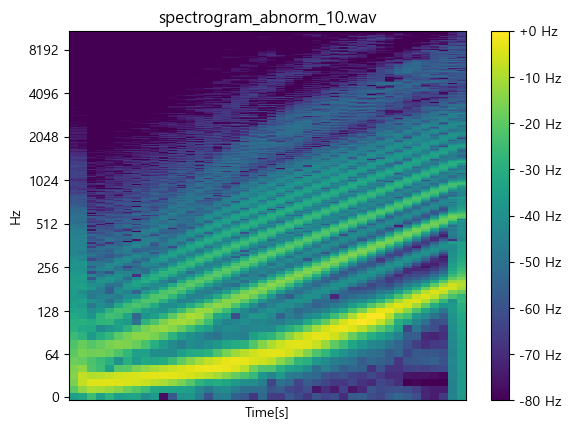

In [7]:
# 파일을 불러와 spectrogram_y, spectrogram_sr로 저장한다
spectrogram_y, spectrogram_sr = librosa.load(file_names_p[1], mono=True)
# 시작과 끝을 지정한 후
start = int(spectrogram_sr) * 0
end = int(spectrogram_sr) * 1
# 음원을 특정시간 주기로 쪼갠 후,
stft = librosa.stft(spectrogram_y[start:end])
stft_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
# 변환된 주파수 대역의 스펙토그램을 보여준다
librosa.display.specshow(stft_db, sr=spectrogram_sr, cmap='viridis', y_axis='log')
plt.xlabel('Time[s]') # x축 제목
plt.ylabel('Hz') # y축 제목
# format은 지도와 같이 복잡한 내용을 표현할 수 있게 해주는 옵션
plt.colorbar(format="%+2.0f Hz")
# 시각화 차트 제목
plt.title('spectrogram_' + file_names_p[1].split('\\')[-1])
# 차트를 그린다.
plt.show()

In [8]:
# 4-2
def get_features(file_name , sample_rate):
    # (전처리) 음향 데이터의 특징점 librosa 라이브러리로 특징점 추출
    y, sr = librosa.load(file_name, sr =sample_rate)
    # file_name : 해당 file 전체path,
    # sr=none 지정시 defualt sr 22050 값으로 반영 (본문은 original data 사용)
    print("Sample Rate: ",sr , " , Audio Shape:",y.shape)
    print("Audio Length: ", y.shape[0]/float(sr),'secs')
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=50)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    # y : 입력 Audio Source
    # sr : load 시 Sample Rate 값으로 반영 필요
    # n_mfcc : default 값은 20, 다양한 특징을 잡기 위해 range는 10~50로 임의 반영
    
    # mfcc로 특징점 추출된 shape 확인하기
    print("mfcc Shape: ",mfcc.shape)
    print("Chroma Shape: ", chroma.shape)
    
    return mfcc, chroma

In [9]:
# 4-3
# 라벨링 할 변수 생성
x_data =[]
y_data =[]
# 라벨링 할 함수 만들기
def feature_labeling(file_name, features):
    buffer=[]
    mfcc, chroma = features
    print("*", file_name)
    for element in mfcc:
        # mfcc가 추출한 특징의 평균값 사용
        buffer.append(np.mean(element))
    for element in chroma:
        # mfcc가 추출한 특징의 평균값 사용
        buffer.append(np.mean(element))
    # train할 데이터 Set 으로 만들기
    x_data.append(buffer)
    # train할 Labeling Set 으로 만들기
    if 'normal' in file_name:
        y_data.append(0) # 양품
    elif 'abnorm' in file_name:
        y_data.append(1) # 불량

In [10]:
# 4-4
# (수행) 전체 파일 특징점 추출 및 라벨링 데이터 취득
for i ,file_name in enumerate(file_names_p):
 # 위에서 만든 getMfcc 함수 호출
 g_mfcc = get_features(file_name, sample_rate)
 #feature_labeling 함수 호출
 feature_labeling(file_name, g_mfcc)

Sample Rate:  192000  , Audio Shape: (587536,)
Audio Length:  3.0600833333333335 secs
mfcc Shape:  (50, 1148)
Chroma Shape:  (12, 1148)
* D:\Desktop\AI_programming\Final\Dataset_전자부품(음향기기) 품질보증 AI 데이터셋\data2\abnorm\abnorm_1.wav
Sample Rate:  192000  , Audio Shape: (587536,)
Audio Length:  3.0600833333333335 secs
mfcc Shape:  (50, 1148)
Chroma Shape:  (12, 1148)
* D:\Desktop\AI_programming\Final\Dataset_전자부품(음향기기) 품질보증 AI 데이터셋\data2\abnorm\abnorm_10.wav
Sample Rate:  192000  , Audio Shape: (587536,)
Audio Length:  3.0600833333333335 secs
mfcc Shape:  (50, 1148)
Chroma Shape:  (12, 1148)
* D:\Desktop\AI_programming\Final\Dataset_전자부품(음향기기) 품질보증 AI 데이터셋\data2\abnorm\abnorm_100.wav
Sample Rate:  192000  , Audio Shape: (587536,)
Audio Length:  3.0600833333333335 secs
mfcc Shape:  (50, 1148)
Chroma Shape:  (12, 1148)
* D:\Desktop\AI_programming\Final\Dataset_전자부품(음향기기) 품질보증 AI 데이터셋\data2\abnorm\abnorm_101.wav
Sample Rate:  192000  , Audio Shape: (587536,)
Audio Length:  3.0600833333333335 se

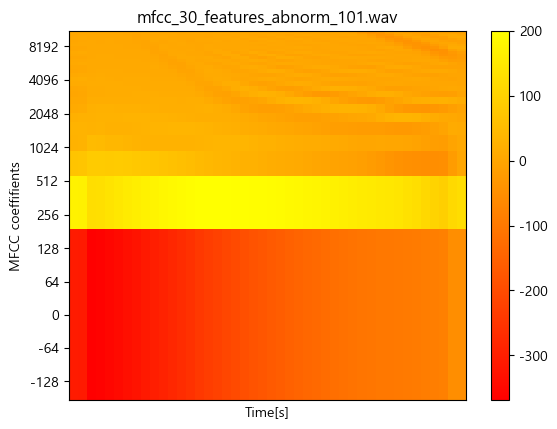

In [11]:
# 파일을 특성을 mfcc_y, mfcc_sr로 저장한다.
mfcc_y, mfcc_sr = librosa.load(file_names_p[3], mono=True)
# start, end값을 정한다.
start = int(mfcc_sr) * 0
end = int(mfcc_sr) * 1
# mfcc특징을 추출한 값을 mfcc에 저장한 후, specshow로 시각화한다.
mfcc = librosa.feature.mfcc(y=mfcc_y[start:end], sr=mfcc_sr, n_mfcc=30)
librosa.display.specshow(mfcc, sr=mfcc_sr, cmap='autumn', y_axis='log')

plt.xlabel('Time[s]') # x축 제목
plt.ylabel('MFCC coeffifients') # y축 제목
# 시각화 그릴 때 마이너스(-) 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False
# 차트의 영역에 칼라바를 포함
plt.colorbar()
# 차트 제목
plt.title('mfcc_30_features_' + file_names_p[3].split('\\')[-1])
plt.show()

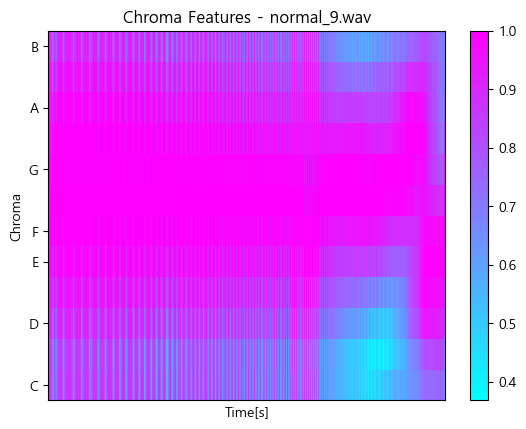

In [12]:
# 파일을 특성을 chroma_y, chroma_sr로 저장한다.
chroma_y, chroma_sr = librosa.load(file_name, sr=sample_rate, mono=True)
# start, end값을 정한다.
start = int(chroma_sr) * 0
end = int(chroma_sr) * 1
# chroma특징을 추출한 값을 chroma에 저장한 후, specshow로 시각화한다.
chroma = librosa.feature.chroma_stft(y=chroma_y[start:end], sr=chroma_sr)
librosa.display.specshow(chroma, sr=chroma_sr, cmap='cool', y_axis='chroma')

plt.xlabel('Time[s]') # x축 제목
plt.ylabel('Chroma') # y축 제목
# 시각화 그릴 때 마이너스(-) 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False
# 차트의 영역에 칼라바를 포함
plt.colorbar()
# 차트 제목
plt.title('Chroma Features - ' + file_name.split('\\')[-1])
plt.show()

In [13]:
# x_data, y_data 값을 array형태로 변환
x_data = np.array(x_data)
y_data = np.array(y_data)
# x_data, y_data shape 확인
print('x_data----->', x_data.shape)
print('y_data----->', y_data.shape)

x_data-----> (348, 62)
y_data-----> (348,)


In [14]:
# 원본 (훈련,라벨) 데이터 훈련 준비
x = x_data.reshape(x_data.shape[0], x_data.shape[1], 1, 1)
# y를 원핫인코딩 한후, x데이터와 shape 맞추기
y = tf.keras.utils.to_categorical(y_data, 2)
#x,y shape 맞는지 확인
print('x.shape', x.shape)
print('y.shape', y.shape)

x.shape (348, 62, 1, 1)
y.shape (348, 2)


In [15]:
# 원본 데이터의 훈련 및 Test 비율 7:3 설정
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True)
# train , test 형태 확인
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(243, 62, 1, 1) (105, 62, 1, 1) (243, 2) (105, 2)


In [16]:
# 모델 CNN 생성
model = Sequential()
# 32개의 필터를 가지는 3x3 커널 크기의 Conv2D 레이어 추가
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))
# 2x2 풀 크기의 MaxPooling2D 레이어 추가
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# 64개의 필터를 가지는 3x3 커널 크기의 Conv2D 레이어 추가
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
# 2x2 풀 크기의 MaxPooling2D 레이어 추가
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# 2차원 데이터를 1차원으로 평탄화하는 Flatten 레이어 추가
model.add(Flatten())
# 히든레이어의 노드개수는 128개 활성화함수는 relu를 사용한다.
model.add(Dense(128, activation='relu'))
# 오버피팅 방지한것으로 이전레이어의 출력을 20%를 0으로 만든다.
model.add(Dropout(0.2))
# 결국 출력될 값이 0, 1(합/불량) 라벨값이 2개이니 Dense는 2개로 출력하고 활성화함수는 softmax를 사용한다.
model.add(Dense(2, activation='softmax'))

In [17]:
# 과적합 방지를 위해 learning_rate test 후 설정 
opt = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
# train , test 형태 확인
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
# 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

(243, 62, 1, 1) (105, 62, 1, 1) (243, 2) (105, 2)


In [18]:
# 모델 학습시키기, 매 epoch마다 훈련손실값(loss), 훈련정확도(acc), 검증손실값(val_loss), 검증정확도(val_acc)를 확인한다.
hist = model.fit(x_train, y_train, epochs=200, batch_size=64, validation_data=(x_test, y_test), verbose=2)

Epoch 1/200
4/4 - 1s - 351ms/step - accuracy: 0.2140 - loss: 2.2720 - val_accuracy: 0.1524 - val_loss: 2.1355
Epoch 2/200
4/4 - 0s - 20ms/step - accuracy: 0.1975 - loss: 2.1228 - val_accuracy: 0.1524 - val_loss: 1.9769
Epoch 3/200
4/4 - 0s - 20ms/step - accuracy: 0.2058 - loss: 2.0126 - val_accuracy: 0.1524 - val_loss: 1.8224
Epoch 4/200
4/4 - 0s - 20ms/step - accuracy: 0.2140 - loss: 2.0075 - val_accuracy: 0.1524 - val_loss: 1.6723
Epoch 5/200
4/4 - 0s - 18ms/step - accuracy: 0.2634 - loss: 1.5809 - val_accuracy: 0.1524 - val_loss: 1.5295
Epoch 6/200
4/4 - 0s - 19ms/step - accuracy: 0.2716 - loss: 1.5770 - val_accuracy: 0.1524 - val_loss: 1.3959
Epoch 7/200
4/4 - 0s - 20ms/step - accuracy: 0.2881 - loss: 1.4212 - val_accuracy: 0.1524 - val_loss: 1.2723
Epoch 8/200
4/4 - 0s - 21ms/step - accuracy: 0.3004 - loss: 1.3820 - val_accuracy: 0.1524 - val_loss: 1.1599
Epoch 9/200
4/4 - 0s - 21ms/step - accuracy: 0.3086 - loss: 1.3458 - val_accuracy: 0.1524 - val_loss: 1.0577
Epoch 10/200
4/4 -

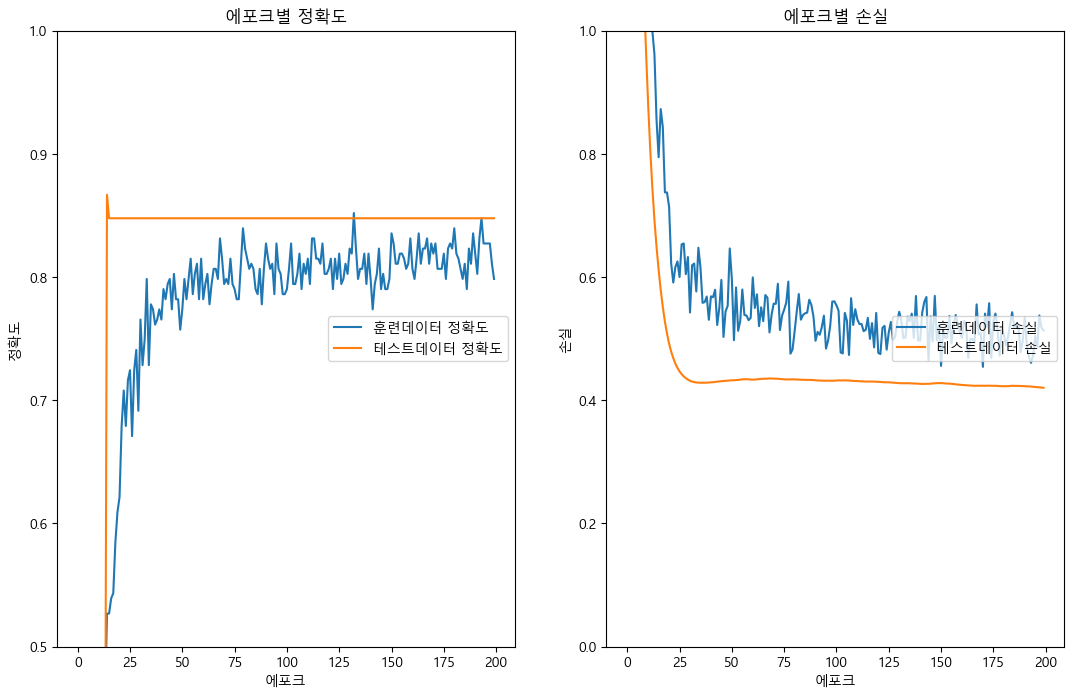

In [19]:
# 모델 학습시각화 크기
plt.figure(figsize=(13, 8))
# Section_1[acc]
# 1열에 그래프를 그리는데 두개의 그래프 중 첫번째 위치에 그린다
plt.subplot(1, 2, 1)
# accuracy값을 그래프에 그린다
plt.plot(hist.history['accuracy'], label='훈련데이터 정확도')
# val_accuracy를 그래프에 그린다
plt.plot(hist.history['val_accuracy'], label='테스트데이터 정확도')
# 첫번째 차트 제목
plt.title('에포크별 정확도')
# 첫번째 차트 x축 이름
plt.xlabel('에포크')
# 첫번째 차트 y축 이름
plt.ylabel('정확도')
# Y축의 범위: [ymin, ymax]
plt.ylim([0.5, 1])
# 범례를 오른쪽으로 위치시킨다.
plt.legend(loc='right')
# Section_2[loss]
# 1열에 그래프를 그리는데 두개의 그래프 중 두번째 위치에 그린다
plt.subplot(1, 2, 2)
# loss값을 그래프에 그린다.
plt.plot(hist.history['loss'], label='훈련데이터 손실')
# val_loss 값을 그래프에 그린다.
plt.plot(hist.history['val_loss'], label='테스트데이터 손실')
# 2번째 차트 제목
plt.title('에포크별 손실')
# 2번째 차트 x축 이름
plt.xlabel('에포크')
# 2번째 차트 y축 이름
plt.ylabel('손실')
# Y축의 범위: [ymin, ymax]
plt.ylim([0, 1])
# 범례를 오른쪽에 위치시킨다
plt.legend(loc='right')

In [20]:
model.build()
# envluate는 위의 모델에 대한 성능을 나타낸다.
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('## evaluation loss and_metrics ##')
# 모델 성능평가하기
print(loss_and_metrics)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8745 - loss: 0.3728 
## evaluation loss and_metrics ##
[0.42008501291275024, 0.8476190567016602]


In [21]:
# 모델 예측
prediction = model.predict(x_test)
# array형식으로 변경, axis=1 이면 행
y_test = np.argmax(y_test, axis=1)
prediction = np.argmax(prediction, axis=1)
# 실제 레이블
print('y_test', y_test)
# 예측 데이터
print('prediction', prediction)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
y_test [1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1]
prediction [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [22]:
#예측 정확도 평가
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
print('정확도 : ', accuracy_score(y_test, prediction)) # 예측 정확도 출력
print('정밀도 : ', precision_score(y_test, prediction)) # 예측 정밀도 출력
print('재현율 : ', recall_score(y_test, prediction)) # 예측 재현율 출력
print('f1 score: ', f1_score(y_test, prediction)) # 예측 f1score 출력

정확도 :  0.8476190476190476
정밀도 :  0.8476190476190476
재현율 :  1.0
f1 score:  0.9175257731958762


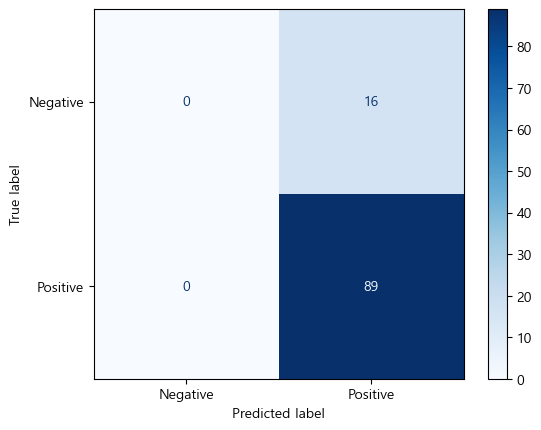

In [23]:
# 라벨링 해준다.
labels=[ "Negative", "Positive"]
# 실제값(정답)과 예측 한것을 표로 만든 평가표
cm = confusion_matrix(y_test, prediction)
# confusion_matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
# cmap 는 색상
disp.plot(cmap=plt.cm.Blues)
plt.show()